In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# path="/content/drive/MyDrive/Research/Hard_Attention/dataset_2/m_5_size_100/run_"

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/hard_attention')

# Generate dataset

In [5]:
np.random.seed(1)

y = np.concatenate((np.zeros(500),np.ones(500),np.ones(500)*2,np.ones(500)*3,np.ones(500)*4,
                    np.ones(500)*5,np.ones(500)*6,np.ones(500)*7,np.ones(500)*8,np.ones(500)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [6]:
x = np.zeros((5000,2))

In [7]:
np.random.seed(12)

x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))

In [8]:
x[idx[0]][0], x[idx[2]][5] 

(array([4.04729858, 6.43185741]), array([4.53008447, 4.5079931 ]))

In [9]:
print(x.shape,y.shape)

(5000, 2) (5000,)


In [10]:
idx= []
for i in range(10):
  idx.append(y==i)

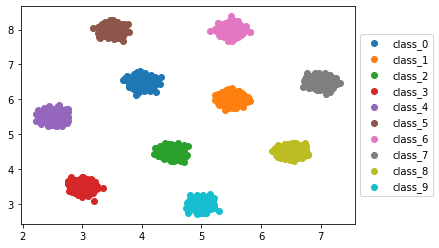

In [11]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
x = ( x -  np.mean(x,axis=0,keepdims=True) ) / np.std(x,axis=0,keepdims=True) 


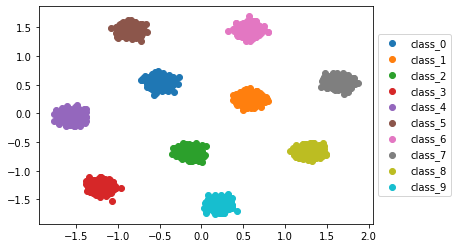

In [13]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [15]:
desired_num = 1100
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
m = 2000
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|███████████████████████████████████████| 1100/1100 [00:34<00:00, 32.34it/s]


In [16]:
# mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [17]:
len(mosaic_list_of_images), mosaic_list_of_images[0],mosaic_list_of_images[0].shape

(1100,
 array([[ 1.41860713, -0.6338838 ],
        [ 0.60177752,  1.40622261],
        [ 0.64672986,  1.41882828],
        ...,
        [ 0.1760838 , -1.64428378],
        [ 0.57482959,  1.52453398],
        [ 1.71875213,  0.627341  ]]),
 (2000, 2))

In [18]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [19]:
batch = 50
msd1 = MosaicDataset(mosaic_list_of_images[0:100], mosaic_label[0:100] , fore_idx[0:100])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [20]:
data,_,_=iter(train_loader).next()

In [21]:
data.shape

torch.Size([50, 2000, 2])

In [22]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[100:], mosaic_label[100:] , fore_idx[100:])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [23]:
class Focus(nn.Module):
    def __init__(self):
        super(Focus, self).__init__()
        self.fc1 = nn.Linear(2,50, bias=False)
        self.fc2 = nn.Linear(50,1,bias=False)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        #self.fc2 = nn.Linear(64, 1, bias=False)
        #torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self,z):
        #print("data",z)
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,2*1)
        alp1,ft1 = self.helper(z)

        alpha = F.softmax(alp1,dim=1)
        #print(self.training)
        
        if self.training:
            alpha =alpha[:,:,0]
            y = ft1 
            return alpha,y
        else:
            #alpha_cumsum = torch.cumsum(alpha, dim = 1)
            #print(alpha_cumsum)
            #len_batch = alpha_cumsum.size(0)
            #patches = alpha_cumsum.size(1)
            #rand_prob = torch.rand(len_batch,patches, 1).to(device)
            #alpha_relu = F.relu(rand_prob-alpha_cumsum)
            #print(alpha_relu)
            #alpha_index = torch.count_nonzero(alpha_relu,dim=1)
            #alpha_hard = F.one_hot(alpha_index,num_classes=patches)
            #print(alpha_hard)
            #alpha_hard = torch.transpose(alpha_hard,dim0=1,dim1=2)
            #print(ft1,"alpha_hard",alpha_hard) 
            #y = torch.sum(alpha_hard*ft1,dim=1)
            #print(alpha,alpha.shape)
         
        
            index = torch.argmax(alpha,dim=1)
            hard_alpha = torch.nn.functional.one_hot(index[:,0], patches)
            y = torch.sum(hard_alpha[:,:,None]*ft1,dim=1)
            alpha = alpha[:,:,0]
            return alpha,y
    
    def helper(self, x):
        x1 = x
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x,x1

In [24]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 3)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)

  def forward(self, x):
    #print(x.shape)
    #x = x.view(-1, 1)
    #print(x.shape)
    x = self.fc1(x)
    # print(x.shape)
    return x

In [25]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net = focus_net.to(device)

In [26]:
torch.manual_seed(12)
classify = Classification().double()
classify = classify.to(device)

In [27]:
import torch.optim as optim
optimizer_classify = optim.Adam(classify.parameters(), lr=0.05 ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.05 ) #, momentum=0.9)

In [28]:
def my_cross_entropy(output,target,alpha):
    criterion = nn.CrossEntropyLoss(reduce=False)
    
    batch = output.size(0)
    #print(batch)
    patches = output.size(1)
    classes = output.size(2)
    
    
    
    output = torch.reshape(output,(batch*patches,classes))
    
    
    target = target.repeat_interleave(patches)
    
    loss = criterion(output,target)
    
    #print(loss,loss.shape)
    loss = torch.reshape(loss,(batch,patches))
    #print(loss.size())
    final_loss = torch.sum(torch.mul(loss,alpha),dim=1)
    #print(final_loss.shape)
    final_loss = torch.mean(final_loss,dim=0)
    
    
    
    #print(final_loss)
    return final_loss
    
    
    

In [29]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [30]:
def plot_attended_data(trainloader,net,epoch):
    attd_data =[]
    lbls = []
    for data in trainloader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
        alphas, avg_images = focus_net(inputs)
        attd_data.append(avg_images.numpy())
        lbls.append(labels)
    attd_data = np.concatenate(attd_data,axis=0)
    lbls = np.concatenate(lbls,axis=0)
    plt.figure(figsize=(6,8))
    plt.scatter(attd_data[:,0],attd_data[:,1],c=lbls)
    plt.title("EPOCH_"+str(epoch))

In [31]:
correct = 0
total = 0
count = 0
flag = 1


with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    loss = my_cross_entropy(outputs,labels,alphas)
    print(loss)
    # print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1)


print("="*100)



/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor(1.1957, dtype=torch.float64)
tensor(1.1948, dtype=torch.float64)


In [32]:
correct = 0
total = 0
count = 0
flag = 1


with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)


In [33]:
for param in focus_net.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[-0.1235,  0.3437],
        [ 0.1704, -0.2588],
        [ 0.0472,  0.0784],
        [ 0.4953, -0.1659],
        [ 0.3371,  0.3451],
        [ 0.3131, -0.1927],
        [-0.1788,  0.0314],
        [ 0.1934,  0.0747],
        [-0.0699,  0.2935],
        [ 0.0524, -0.1017],
        [-0.2094, -0.3588],
        [ 0.2079, -0.0692],
        [-0.0396,  0.2914],
        [-0.2280,  0.0319],
        [-0.1798,  0.1602],
        [ 0.1488, -0.0822],
        [ 0.2434,  0.1657],
        [-0.1537, -0.0442],
        [-0.2106,  0.2442],
        [-0.1865, -0.1679],
        [-0.3746,  0.1089],
        [ 0.0765,  0.0746],
        [ 0.0194,  0.5148],
        [-0.0150, -0.0721],
        [-0.2615,  0.0124],
        [ 0.2550,  0.0677],
        [ 0.1783, -0.1196],
        [ 0.1869,  0.2055],
        [-0.0041, -0.1310],
        [-0.0923,  0.0208],
        [-0.1519, -0.2190],
        [-0.0142, -0.0720],
        [ 0.1204,  0.0586],
        [-0.2943,  0.2803],
        [ 0

In [34]:
nos_epochs = 2000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    batch = inputs.size(0)
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = my_cross_entropy(outputs, labels,alphas) 
    
    loss.backward()
    
    
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 2
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1

  if(np.mean(epoch_loss) <= 0.01):
      break;
  #plot_attended_data(train_loader,focus_net,epoch)

    
print('Finished Training')

[1,     2] loss: 1.168
[2,     2] loss: 1.107
[3,     2] loss: 1.095
[4,     2] loss: 1.095
[5,     2] loss: 1.086
[6,     2] loss: 1.088
[7,     2] loss: 1.088
[8,     2] loss: 1.086
[9,     2] loss: 1.087
[10,     2] loss: 1.086
[11,     2] loss: 1.085
[12,     2] loss: 1.087
[13,     2] loss: 1.090
[14,     2] loss: 1.086
[15,     2] loss: 1.086
[16,     2] loss: 1.088
[17,     2] loss: 1.086
[18,     2] loss: 1.087
[19,     2] loss: 1.086
[20,     2] loss: 1.085
[21,     2] loss: 1.089
[22,     2] loss: 1.086
[23,     2] loss: 1.087
[24,     2] loss: 1.085
[25,     2] loss: 1.085
[26,     2] loss: 1.089
[27,     2] loss: 1.088
[28,     2] loss: 1.087
[29,     2] loss: 1.085
[30,     2] loss: 1.085
[31,     2] loss: 1.088
[32,     2] loss: 1.086
[33,     2] loss: 1.086
[34,     2] loss: 1.087
[35,     2] loss: 1.085
[36,     2] loss: 1.087
[37,     2] loss: 1.085
[38,     2] loss: 1.085
[39,     2] loss: 1.089
[40,     2] loss: 1.087
[41,     2] loss: 1.085
[42,     2] loss: 1.085
[

[336,     2] loss: 1.085
[337,     2] loss: 1.086
[338,     2] loss: 1.085
[339,     2] loss: 1.086
[340,     2] loss: 1.086
[341,     2] loss: 1.085
[342,     2] loss: 1.085
[343,     2] loss: 1.087
[344,     2] loss: 1.085
[345,     2] loss: 1.087
[346,     2] loss: 1.086
[347,     2] loss: 1.087
[348,     2] loss: 1.087
[349,     2] loss: 1.085
[350,     2] loss: 1.085
[351,     2] loss: 1.085
[352,     2] loss: 1.088
[353,     2] loss: 1.087
[354,     2] loss: 1.086
[355,     2] loss: 1.087
[356,     2] loss: 1.086
[357,     2] loss: 1.087
[358,     2] loss: 1.085
[359,     2] loss: 1.086
[360,     2] loss: 1.085
[361,     2] loss: 1.086
[362,     2] loss: 1.085
[363,     2] loss: 1.086
[364,     2] loss: 1.085
[365,     2] loss: 1.085
[366,     2] loss: 1.085
[367,     2] loss: 1.087
[368,     2] loss: 1.085
[369,     2] loss: 1.086
[370,     2] loss: 1.088
[371,     2] loss: 1.087
[372,     2] loss: 1.086
[373,     2] loss: 1.086
[374,     2] loss: 1.087
[375,     2] loss: 1.085


[665,     2] loss: 1.086
[666,     2] loss: 1.086
[667,     2] loss: 1.087
[668,     2] loss: 1.087
[669,     2] loss: 1.086
[670,     2] loss: 1.087
[671,     2] loss: 1.086
[672,     2] loss: 1.086
[673,     2] loss: 1.086
[674,     2] loss: 1.085
[675,     2] loss: 1.085
[676,     2] loss: 1.086
[677,     2] loss: 1.087
[678,     2] loss: 1.088
[679,     2] loss: 1.085
[680,     2] loss: 1.085
[681,     2] loss: 1.085
[682,     2] loss: 1.089
[683,     2] loss: 1.086
[684,     2] loss: 1.085
[685,     2] loss: 1.085
[686,     2] loss: 1.088
[687,     2] loss: 1.088
[688,     2] loss: 1.086
[689,     2] loss: 1.085
[690,     2] loss: 1.087
[691,     2] loss: 1.089
[692,     2] loss: 1.086
[693,     2] loss: 1.085
[694,     2] loss: 1.086
[695,     2] loss: 1.089
[696,     2] loss: 1.086
[697,     2] loss: 1.086
[698,     2] loss: 1.088
[699,     2] loss: 1.090
[700,     2] loss: 1.087
[701,     2] loss: 1.086
[702,     2] loss: 1.086
[703,     2] loss: 1.086
[704,     2] loss: 1.086


[994,     2] loss: 1.069
[995,     2] loss: 1.072
[996,     2] loss: 1.069
[997,     2] loss: 1.071
[998,     2] loss: 1.069
[999,     2] loss: 1.071
[1000,     2] loss: 1.069
[1001,     2] loss: 1.071
[1002,     2] loss: 1.068
[1003,     2] loss: 1.068
[1004,     2] loss: 1.069
[1005,     2] loss: 1.071
[1006,     2] loss: 1.068
[1007,     2] loss: 1.069
[1008,     2] loss: 1.068
[1009,     2] loss: 1.068
[1010,     2] loss: 1.068
[1011,     2] loss: 1.068
[1012,     2] loss: 1.068
[1013,     2] loss: 1.069
[1014,     2] loss: 1.069
[1015,     2] loss: 1.071
[1016,     2] loss: 1.071
[1017,     2] loss: 1.068
[1018,     2] loss: 1.068
[1019,     2] loss: 1.068
[1020,     2] loss: 1.068
[1021,     2] loss: 1.068
[1022,     2] loss: 1.067
[1023,     2] loss: 1.069
[1024,     2] loss: 1.067
[1025,     2] loss: 1.069
[1026,     2] loss: 1.068
[1027,     2] loss: 1.068
[1028,     2] loss: 1.067
[1029,     2] loss: 1.070
[1030,     2] loss: 1.069
[1031,     2] loss: 1.068
[1032,     2] loss

[1312,     2] loss: 1.061
[1313,     2] loss: 1.061
[1314,     2] loss: 1.061
[1315,     2] loss: 1.059
[1316,     2] loss: 1.060
[1317,     2] loss: 1.063
[1318,     2] loss: 1.059
[1319,     2] loss: 1.060
[1320,     2] loss: 1.061
[1321,     2] loss: 1.060
[1322,     2] loss: 1.060
[1323,     2] loss: 1.060
[1324,     2] loss: 1.060
[1325,     2] loss: 1.060
[1326,     2] loss: 1.063
[1327,     2] loss: 1.060
[1328,     2] loss: 1.060
[1329,     2] loss: 1.061
[1330,     2] loss: 1.062
[1331,     2] loss: 1.060
[1332,     2] loss: 1.060
[1333,     2] loss: 1.061
[1334,     2] loss: 1.062
[1335,     2] loss: 1.060
[1336,     2] loss: 1.061
[1337,     2] loss: 1.059
[1338,     2] loss: 1.063
[1339,     2] loss: 1.062
[1340,     2] loss: 1.060
[1341,     2] loss: 1.060
[1342,     2] loss: 1.059
[1343,     2] loss: 1.060
[1344,     2] loss: 1.059
[1345,     2] loss: 1.059
[1346,     2] loss: 1.059
[1347,     2] loss: 1.059
[1348,     2] loss: 1.060
[1349,     2] loss: 1.060
[1350,     2

[1628,     2] loss: 1.057
[1629,     2] loss: 1.057
[1630,     2] loss: 1.061
[1631,     2] loss: 1.057
[1632,     2] loss: 1.058
[1633,     2] loss: 1.057
[1634,     2] loss: 1.058
[1635,     2] loss: 1.058
[1636,     2] loss: 1.059
[1637,     2] loss: 1.057
[1638,     2] loss: 1.057
[1639,     2] loss: 1.057
[1640,     2] loss: 1.057
[1641,     2] loss: 1.056
[1642,     2] loss: 1.056
[1643,     2] loss: 1.060
[1644,     2] loss: 1.057
[1645,     2] loss: 1.058
[1646,     2] loss: 1.057
[1647,     2] loss: 1.056
[1648,     2] loss: 1.059
[1649,     2] loss: 1.057
[1650,     2] loss: 1.057
[1651,     2] loss: 1.056
[1652,     2] loss: 1.057
[1653,     2] loss: 1.056
[1654,     2] loss: 1.056
[1655,     2] loss: 1.060
[1656,     2] loss: 1.057
[1657,     2] loss: 1.056
[1658,     2] loss: 1.057
[1659,     2] loss: 1.057
[1660,     2] loss: 1.056
[1661,     2] loss: 1.057
[1662,     2] loss: 1.058
[1663,     2] loss: 1.056
[1664,     2] loss: 1.059
[1665,     2] loss: 1.057
[1666,     2

[1946,     2] loss: 1.057
[1947,     2] loss: 1.055
[1948,     2] loss: 1.057
[1949,     2] loss: 1.057
[1950,     2] loss: 1.055
[1951,     2] loss: 1.057
[1952,     2] loss: 1.056
[1953,     2] loss: 1.060
[1954,     2] loss: 1.055
[1955,     2] loss: 1.058
[1956,     2] loss: 1.058
[1957,     2] loss: 1.058
[1958,     2] loss: 1.055
[1959,     2] loss: 1.056
[1960,     2] loss: 1.057
[1961,     2] loss: 1.055
[1962,     2] loss: 1.057
[1963,     2] loss: 1.057
[1964,     2] loss: 1.056
[1965,     2] loss: 1.056
[1966,     2] loss: 1.056
[1967,     2] loss: 1.056
[1968,     2] loss: 1.055
[1969,     2] loss: 1.055
[1970,     2] loss: 1.056
[1971,     2] loss: 1.060
[1972,     2] loss: 1.057
[1973,     2] loss: 1.055
[1974,     2] loss: 1.056
[1975,     2] loss: 1.057
[1976,     2] loss: 1.057
[1977,     2] loss: 1.058
[1978,     2] loss: 1.056
[1979,     2] loss: 1.055
[1980,     2] loss: 1.056
[1981,     2] loss: 1.056
[1982,     2] loss: 1.058
[1983,     2] loss: 1.055
[1984,     2

In [35]:
for param in focus_net.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[-0.5742, -0.0939],
        [ 3.8761,  2.3625],
        [-0.9264,  1.3361],
        [ 4.1924,  2.5062],
        [ 4.7235,  3.5504],
        [ 2.3281,  1.3147],
        [-0.2786,  0.0543],
        [ 3.0185,  1.7554],
        [-1.2845,  1.5973],
        [ 4.5624,  3.7230],
        [ 0.8749, -2.4829],
        [ 4.0452,  2.7140],
        [-1.2635,  1.6756],
        [ 3.4489,  2.2617],
        [-1.0524,  1.3988],
        [-0.2171, -0.6286],
        [ 3.0786,  1.7339],
        [ 1.2367, -3.5337],
        [-0.2618,  0.9580],
        [ 0.9883, -2.8456],
        [-0.3838,  0.0869],
        [ 5.1037,  3.6930],
        [-0.5888,  1.1038],
        [ 0.7932, -2.2577],
        [ 6.0361,  4.7597],
        [-0.3549, -0.5545],
        [-0.2567, -0.6760],
        [ 2.2260,  1.8498],
        [ 4.4250,  2.8116],
        [-0.5942,  0.9746],
        [ 0.3488, -2.1302],
        [ 5.5903,  4.1984],
        [ 4.9471,  3.5559],
        [-0.9447,  0.6442],
        [-1

In [36]:
correct = 0
total = 0

focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to(device), labels.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    #print(outputs.shape)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the train images: 45.000000 %
total correct 45
total train set images 100


In [37]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to(device), labels.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the test images: 35.400000 %
total correct 354
total train set images 1000
